In [3]:
#Manejo de matrices y tablas
import numpy as np
import pandas as pd

#Estadistica y funciones matemáticas
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles


#Probabilistic programs
#!pip install pymc3
#!pip install pymc==4.0.0b1
import pymc3 as pm
#import pymc as pm
#import aesara.tensor as at
import theano.tensor as tt 
from theano.compile.ops import as_op
print('Running on PyMC v{}'.format(pm.__version__))


#Graficas
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC3 v3.11.2


# Comparación de modelos
Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

¿Cuál modelo representa mejor la realidad?

<center><img src="img/5_CB/starry-night.jpg" width = "800" height = '800'></center>

# Modelos jerárquicos

<center><img src="img/5_CB/Hierarchy.svg" width = "400" height = '400'></center>

Principales fuentes: Gelman, et al (2013); Kruschke (2014).

Hay muchas estructuras jerarquicas:
* Probabilidad de supervivencia COVID 
    * Depende de país. 
        * Depende del hospital.


* Actividad M1 en decisiones económicas (motor cortex)
    * Depende de SMA (supplementary motor area)
        * Depende de IPS (intraparietal sulcus; acum. evidencia)
            * Depende de vmPFC (ventromedial prefrontal cortex; valor subjetivo)

## Primer ejemplo: Riesgo de tumor en ratas

Descripción: determinar $\theta$, la probabilidad de tumor en ratas de laboratorio (F344) que no reciben medicamento experimental.

Datos: un experimento que se acaba de hacer. 70 grupos de ratas testeadas antes. 

Este ejemplo se va a modelar de forma jerárquica y con priors basados en data anterior. 

In [4]:
#Data
rats = pd.DataFrame(
    np.loadtxt("data/5_CB/rats.asc", skiprows=1), 
    columns = ['y','n']
)
rats.loc[0:20,:] #y: with tumor; n: total rats


,y,n
0,0.0,20.0
1,0.0,20.0
2,0.0,20.0
3,0.0,20.0
4,0.0,20.0
5,0.0,20.0
6,0.0,20.0
7,0.0,19.0
8,0.0,19.0
9,0.0,19.0


71 experimentos con j grupos de ratas. 

$\theta_j$ depende de `hiperparámetros` $\alpha, \beta$: 

Hiperparámetros reflejan condiciones del grupo, experimento, o día. 

<center><img src="img/5_CB/model_rats.svg" width = "801" height = '800'></center>

Las distribuciones para $y_j$ & $\theta_j$:
* Beta esta entre [0,1], perfecto para proporciones.
* Binomial, es discreta para conteos.

La distribución $p(\alpha,\beta)$:
* Uniforme entre $$\left[\frac{\alpha}{\alpha+\beta}, (\alpha+\beta)^{-5/2} \right]$$
* El 1er extremo es el promedio de $\theta_j$
* El 2do extremo depende del denominador del promedio de $\theta_j$: $\alpha + \beta$
* $(\alpha + \beta)^{-5/2}$, es luego de volver a las variables originales (ver Gelman, et al, 2013, Hierarchical Models).

In [ ]:
#El prior para alpha y beta castiga valores altos de alpha+beta
#Castigar significa que les asigna cada vez menos probabilidad
alpha = np.random.randint(0,100,500)
beta = np.random.randint(0,100,500)
y = (alpha+beta)**(-5/2)
plt.scatter(alpha+beta, y);
plt.ylabel('$p(\\alpha,\\beta)$')
plt.xlabel('$\\alpha+\\beta$');

In [5]:
# p(alpha,beta) en log (el algoritmo trabaja con logs)
def logp_ab(a,b):
    return tt.log(tt.pow(a+b, -5/2))
with pm.Model() as model: 
    #Priors
    a = pm.Uniform('alpha', 0.05, 100)
    b = pm.Uniform('beta', 0.05, 100)    
    pm.Potential('p(a, b)', logp_ab(a,b)) 
    #Pueden remover el Potential (es simila a increase_log de stan)
    #(pero ver Gelman, 2013, Ch 5, ed 3)
    #El algoritmo no falla si castigamos alpha + beta.
    
    theta = pm.Beta('theta', alpha=a, beta=b, 
                    shape=rats.shape[0])
    
    #Likelihoods
    y = pm.Binomial('y', p=theta, n=rats.loc[:,'n'], 
                    observed=rats.loc[:,'y'])
    
    # Sampleo
    trace = pm.sample(5000, target_accept=.95)
    #the step size in PyMC3 is tuned automatically during warm up, 
    #but we can coerce smaller step sizes by tweaking the configuration 
    #of PyMC3’s adaptation routine. In particular, we can increase the 
    #target_accept parameter from its default value of 0.8 closer 
    #to its maximum value of 1
    ##posterior_predictive = pm.sample_posterior_predictive(trace)
 

<ipython-input-5-1cd1ba234631>:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, target_accept=.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 36 seconds.
The number of effective samples is smaller than 25% for some parameters.


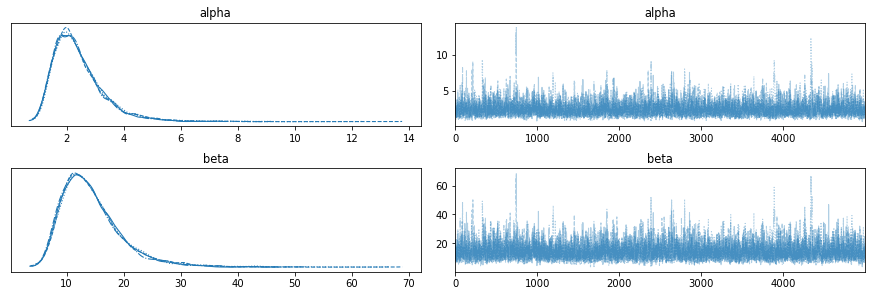

In [6]:
# Combina bien
beta_samples = trace["beta"]
alpha_samples = trace["alpha"]
data = az.from_pymc3(trace=trace, model=model)
az.plot_trace(data, var_names=['alpha', 'beta']);
plt.savefig('img/5_CB/trace_rats.svg')
#plt.close()

Combina bien

<center><img src="img/5_CB/trace_rats.svg" width = "801" height = '800'></center>

C:\ProgramData\Anaconda3\lib\site-packages\arviz\utils.py:409: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_cov" failed type inference due to: Untyped global name '_dot': cannot determine Numba type of <class 'arviz.utils.maybe_numba_fn'>

File "C:\ProgramData\Anaconda3\lib\site-packages\arviz\utils.py", line 421:
def _cov(data):
    <source elided>
        x -= avg[:, None]
        prod = _dot(x, x.T.conj())
        ^

  @conditional_jit(cache=True)
C:\ProgramData\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:177: NumbaWarning: Function "_cov" was compiled in object mode without forceobj=True.

File "C:\ProgramData\Anaconda3\lib\site-packages\arviz\utils.py", line 410:
@conditional_jit(cache=True)
def _cov(data):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\ProgramData\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to 

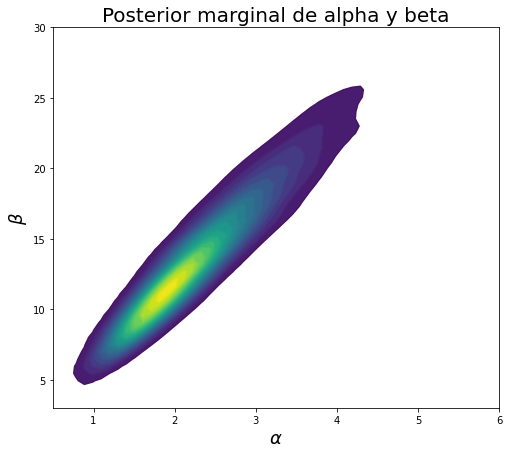

In [7]:
fig, ax = plt.subplots(figsize=(8, 7))
az.plot_kde(values=alpha_samples, values2=beta_samples, 
            ax=ax, contour=True, 
            contour_kwargs={'colors': None, "levels":20,  'cmap': 'viridis'},
            contourf_kwargs={"levels":20})
ax.set_xlim([0.5,6]); ax.set_ylim([3,30]);
plt.xlabel(r'$\alpha$', fontsize = 18)
plt.ylabel(r'$\beta$', fontsize = 18)
plt.title('Posterior marginal de alpha y beta', fontsize = 20);
#fig.savefig('img/5_CB/posterior_rats_ab.svg')
#plt.close()

Posterior de los hiperparametros
<center><img src="img/5_CB/posterior_rats_ab.svg" width = "600" height = '600'></center>

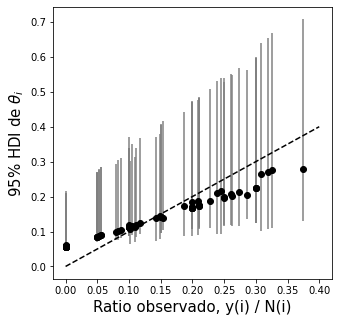

In [8]:
median_theta = np.median(trace['theta'], axis=0)
hdi_ = az.hdi(trace['theta'][None,:], hdi_prob=.95)

plt.figure(figsize=(5, 5))
plt.errorbar(rats.loc[:, 'y'] / rats.loc[:, 'n'], median_theta, fmt='o',
             yerr=[hdi_[:, 0], hdi_[:, 1]], ecolor='gray', 
             markerfacecolor='k', mec='k')
plt.plot(np.linspace(0, .4, 10), np.linspace(0, .4, 10), 'k--')
plt.xlabel('Ratio observado, y(i) / N(i)', fontsize = 15)
plt.ylabel(r'95% HDI de $\theta_i$', fontsize = 15);
plt.savefig('img/5_CB/posterior2_rats_ab.svg')
#plt.close()

El modelo predice bien las proporciones (linea punteada modelo separado)
<center><img src="img/5_CB/posterior2_rats_ab.svg" width = "501" height = '500'></center>

In [ ]:
# Comparación del modelo separado (cada experimento aparte) 
# y el jerárquico.
x = np.linspace(0, 1, 250)
# binomial likelihood, beta (1,1) prior , 
# resulting posterior is beta(y+1,n-y+1)
# Por claridad, solo cada 7a distribución
theta_sep = st.beta.rvs(a = rats.iloc[0:-1:7,0] + 1, 
                        b = rats.iloc[0:-1:7,1] - rats.iloc[0:-1:7,0] + 1,
                        size = [5000,rats.iloc[0:-1:7,0].shape[0]]) 

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
# Modelo separado
t = theta_sep
az.plot_density([t[:,0],t[:,1],t[:,2],t[:,3],t[:,4],
                t[:,5],t[:,6],t[:,7],t[:,8],t[:,9]], 
                hdi_prob=1, ax = axes[0], colors = 'blue')
axes[0].set_yticks(())
axes[0].set_title('Modelo separado', fontsize = 20)
axes[0].set_ylim((0, axes[0].set_ylim()[1]))  # set y base to zero
axes[0].set_xlim((0, 1))
axes[0].get_legend().remove()
# Modelo jerárquico. Los posteriors para theta_j son
# más angostos que los del modelo separado. El modelo 
# jerárquico toma en cuenta info. de los otros theta_j.
# Por claridad, solo cada 7a distribución
t = trace['theta']
az.plot_density([t[:,0],t[:,7],t[:,14],t[:,21],t[:,28],
                t[:,35],t[:,42],t[:,49],t[:,56],t[:,63]], 
                hdi_prob=1, ax = axes[1], colors = 'green')
axes[1].set_yticks(())
axes[1].set_xlabel(r'$\theta$', fontsize = 20)
axes[1].set_title('Modelo jerárquico', fontsize = 20)
axes[1].set_ylim((0, axes[1].set_ylim()[1]))
axes[1].set_xlim((0, 1))
axes[1].get_legend().remove()
fig.tight_layout()
fig.savefig('img/5_CB/posterior3_rats_ab.svg')
#plt.close()

$\theta_j$ son más angostos que los del modelo separado. 
Modelo jeráquico tiene menos incertidumbre agrupandolos via $\alpha$ y $\beta$.
<br> Pero ¿cuál escoger? Veamos otro ejemplo primero.

<center><img src="img/5_CB/posterior3_rats_ab.svg" width = "501" height = '500'></center>

## Segundo ejemplo: ocho colegios

Problema: ¿programas de entrenamiento mejoran puntajes en la prueba de ingreso a la universidad?

Detalles: 8 colegios, cada uno con su propio programa de entrenamiento.

Data: aumento en puntaje (grupo control de cada colegio no hizo el entrenamiento)

Modelo jerárquico

<center><img src="img/5_CB/model_8s.svg" width = "800" height = '800'></center>

In [ ]:
# SAT-example data (SAT: Scholastic Aptitude Test)
# y is the estimated treatment effect
# s is the standard error of effect estimate
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
s = np.array([15, 10, 16, 11,  9, 11, 10, 18])
schools = pd.DataFrame({"Efecto":y, 'SE':s})
schools


In [ ]:
with pm.Model() as model:
    #Priors Jerarquico Superior
    mu = pm.Uniform('mu', 0, 30)
    tau = pm.Uniform('tau', 0, 30)    
    
    #Prior Jerarquico Inferior
    theta = pm.Normal('theta', mu=mu, sigma=tau, 
                      shape=schools.shape[0])
    
    #Likelihood Jerarquico más bajo en el gráfico
    y = pm.Normal('y', mu = theta, sigma = schools.loc[:,'SE'], 
                  observed = schools.loc[:,'Efecto'])
    
    # Sampleo
    trace = pm.sample(10000, tune = 1000, target_accept = 0.99)
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
# Combina bien
mu_samples = trace["mu"]
tau_samples = trace["tau"]
data = az.from_pymc3(trace=trace, model=model)
az.plot_trace(data, var_names=['mu', 'tau']);
plt.savefig('img/5_CB/trace_8s.svg') 
#plt.close()

Combina bien

<center><img src="img/5_CB/trace_8s.svg" width = "701" height = '700'></center>

In [ ]:
az.plot_density(data, var_names=['tau'], hdi_prob=1);
plt.savefig('img/5_CB/density_tau_8s.svg')
#plt.close()

El proceso latente de donde salen los efectos del promedio entrenamiento ($\mu$) no es muy ruidoso

<center><img src="img/5_CB/density_tau_8s.svg" width = "501" height = '500'></center>

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,5))
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
for s in range(schools.shape[0]):
    a = np.array([trace['mu'],
                  trace['tau'],
                  trace['theta'][:,s]]).T
    b = a[a[:,1].argsort()] #sorts by the 2nd column
    trace_sorted = pd.DataFrame(b, 
                                columns = ['mu','tau','theta'])
    toplot_mean = trace_sorted.groupby(pd.cut(trace_sorted["tau"], 
                                         bins=10)).mean()
    ax[0].plot(toplot_mean['tau'],toplot_mean['theta'], label = labels[s])
    toplot_std = trace_sorted.groupby(pd.cut(trace_sorted["tau"], 
                                         bins=10)).std()
    ax[1].plot(toplot_mean['tau'],toplot_std['theta'], label = labels[s])
ax[0].set_xlabel(r'$\tau$', fontsize=18)
ax[0].set_ylabel(r'$E[\theta$]', fontsize=18)
ax[1].set_xlabel(r'$\tau$', fontsize=18)
ax[1].set_ylabel(r'$std[\theta]$', fontsize=18)
ax[0].legend();
plt.tight_layout()
fig.savefig('img/5_CB/tau_theta_8s.svg')
#plt.close()

Un efecto tan fuerte como el de la escuela A (28 puntos de incremento) parece improbable, aún con hiperparametro $\tau$ alto
<center><img src="img/5_CB/tau_theta_8s.svg" width = "700" height = '700'></center>

In [ ]:
az.summary(data)

In [ ]:
maxx = np.amax(trace['theta'], axis = 1)
az.plot_density([trace['theta'][:,0], maxx],
                data_labels=['Escuela A' , 'Mejor efecto'],
                hdi_prob=1);
plt.title("");
plt.savefig("img/5_CB/AvsMax_8s.svg")
#plt.close()

El programa de la escuela A es bueno, pero parece que no hay evidencia que sea siempre el mejor
<center><img src="img/5_CB/AvsMax_8s.svg" width = "551" height = '550'></center>

In [ ]:
# Probabilidad que el programa de la escuela A 
# sea mejor que el del peor en los datos
conteo = np.sum(trace['theta'][:,0]>trace['theta'][:,2])
prob = conteo/trace['theta'].shape[0]
print("Probabilidad que el programa de la escuela A sea mejor que de la escuela C: ", np.round(prob,2))


### Ejercicios (Fuente: Gelman, et al, 3era ed.)

1. Utilicé las muestras del ejemplo de ocho colegios:
    * Para cada escuela, calcule la probabilidad que su programa es el mejor de todos.
    * Para cada par de escuelas j,k calcule la probabilidad que el programa j es mejor que el programa k.    

tip: use np.random.choice

In [ ]:
#Escriba su código acá


2. Repita 1 con $\tau$ fijo y muy grande (esto es equivalente a una estimación separada por colegio). Discuta las diferencias con los resultados del punto 1.


In [ ]:
#Escriba su código acá


3. Utilice la data de las ratas pero ahora trabaje/transforme a la escala log-odds (nota: logit(0) es menos infinito; cambie los ceros por valores cercanos e.g. 1e-200; o alternativamente siga con la data de conteos pero use inverse logit de theta cuando este en el modelo de pymc). \
Tome muestras de $\theta_j \sim Normal(\mu, \tau)$, donde $\tau$ es la desviación estandar ($\theta_j$ está en escala logit). Interprete los resultados en esa escala. Tip: puede usar likelihood normal o binomial. Si usa binomial, use inverse logit de theta_j para p. 
    

In [ ]:
#Escriba su código acá


4. En los alrededores del campus de una universidad se hizo un conteo de tráfico de bicicletas y otros vehiculos. Sesenta bloques se seleccionaron y se observaron por una hora. Los bloques se escogieron acorde a su nivel de actividad (bien ocupado, ocupación normal, y residencial) y si tenían bicirutas o no. La data la puede encontrar en transit.csv. Centrese en las 10 primeras filas. Haga lo siguiente:

    * Un modelo jerárquico como el del tumor de las ratas. Ahora n es el total de vehiculos (bicis+otros) y la variable de interés es la proporción de bicis. Es decir, infiera $\theta_j$, la proporción latente de bicicletas de cada bloque, con la data disponible (solo las 10 primeras filas).
    * Compare la posterior del parámetro $\theta_j$  con las proporciones que hay en la data en cada bloque (# de bicicletas / # vehiculos incluyendo bicicletas). Comente cómo difieren (o no) la proporciones de la data y la inferencia de la posterior del parámetro $\theta_j$
    * Calcule el intervalo posterior al 95% de la proporción de tráfico de bicicletas en todos los bloques.  Agrupe todos los $\theta_j$, queremos un intervalo general.
    * Corra el modelo ahora con los siguientes priors y likelihood:
        * Likelihood para el conteo de bicicletas es una $Poisson(\theta_j)$. Ahora $\theta_j$ es el número promedio de bicis por hora.
        * Prior $Gamma(\alpha,\beta)$ para $\theta_j$. Asigne uniformes para los hiperparámetros $\alpha$ y $\beta$
        * Haga un gráfica con los hiperparámetros (eje x: $\alpha$, eje y: $\beta$)
    
    


In [ ]:
#Escriba su código acá


# Comparar modelos 

En la anterior sección comparamos datos vs. posterior (ver ejemplo ratas). 

Vamos a ver más técnicas/aproximaciones al problema de escoger el mejor modelo.

Una aproximación es pensar el problema como uno jerárquico. <br> 
Dos modelos (m) con diferentes priors y likelihoods. <br> 
La distribución categórica al tope de la jerárquia tiene hiperparámetros. La inferencia los determina. 
<center><img src="img/5_CB/Kruschke1.svg" width = "451" height = '450'></center>

Una empresa que fabrica monedas tiene dos sitios de producción.<br>
Sitio 1: monedas sesgadas a cara e.g. beta(9,4) <br>
Sitio 2: monedas sesgadas a sello e.g. beta(4,9)
<center><img src="img/5_CB/coin.png" width = "351" height = '350'></center>

El problema en representación jerárquica. <br>
Buscamos las prob. posteriores de m=1, m=2 dado los lanzamientos de la moneda $y_i$

<center><img src="img/5_CB/Kruschke2.svg" width = "400" height = '400'></center>

In [ ]:
#Data
N=9
z=6
y_o = [0]*(N-z) +  [1]*z
y_o

In [ ]:
# Models to compare
m1_info = np.array([3,9])
m2_info = np.array([9,3])
# Inference
with pm.Model() as model:
    #Prior for m (model)
    mi = pm.DiscreteUniform('model_index', lower=0, upper=1)
    
    #Samples from the models to test
    thetaM1 = pm.Beta('thetaM1', m1_info[0], m1_info[1] )
    thetaM2 = pm.Beta('thetaM2', m2_info[0], m2_info[1] )
    
    #Likelihood
    theta = pm.Deterministic('theta', (1-mi)*thetaM1 + (mi)*thetaM2) 
    y = pm.Bernoulli('y', theta, observed = y_o)
    
    #Muestras
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step = step, start = start)
    burned_trace = trace[5000:] #burn in ( para este ejemplo, grande por conveniencia: graficas con poco MB).

In [ ]:
data = az.from_pymc3(trace=burned_trace, model=model)
#Convergencia
az.plot_trace(data, figsize = [10,7]);
plt.savefig("img/5_CB/trace_model_bern.svg"); plt.close()
#az.rhat(data) #Si es <1.1 está bien

<center><img src="img/5_CB/trace_model_bern.svg" width = "600" height = '600'></center>

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_density(burned_trace['model_index'], 
                ax = ax[0], colors = 'k')
ax[0].set_title('Indice Modelos', fontsize = 20)
az.plot_density(burned_trace['theta'], 
                ax = ax[1], colors = 'k', hdi_prob=1)
ax[1].set_title(r'Prop. inferida: $\theta$', fontsize = 20);
plt.savefig("img/5_CB/density_model_bern.svg"); plt.close()


In [ ]:
print("p(m=2|D): ", np.round(burned_trace['model_index'].mean(),4))
print("p(theta|D): ", np.round(burned_trace['theta'].mean(),4))
print("Prop. data: ", np.round(z/N,4)) #Data

El posterior del indice sugiere que el modelo 2 es mejor para la data.
<center><img src="img/5_CB/density_model_bern.svg" width = "600" height = '600'></center>

Asumimos priors diferentes ( $\theta_{M1}$, $\theta_{M2}$ ), y el mismo likelihood. 

Es perfectamente valido que los modelos también tengan diferentes likelihoods. 

Vemos como incluirlo en nuestro modelo.

In [ ]:
# No vamos a correr el modelo, pues no tiene sentido.
# Es solo para ver cómo se puede considerar diferentes 
# likelihoods
with model:
    #pm.math.eq(A, B) checks if A==B.
    theta_cond = pm.math.switch(pm.math.eq(mi, 0), 
                                theta, #1er likelihood 
                                2*theta #2do likelihood
                               )
    y_cond = pm.Bernoulli('y_cond', theta_cond, observed = y_o)

## Bayes factor

Una métrica propuesta para cuantificar la ventaja de un modelo sobre otro es con `Bayes factor`. La definición es

$$BF = \frac{p(Data|Modelo_1)}{p(Data|Modelo_2)}$$

Otra formulación equivalente es (no la vamos a demostrar):

\begin{align}
  BF &= \frac{Post_{odds}}{Prior_{odds}}\\
     &= \frac{\frac{p(Modelo_1|Data)}{p(Modelo_2|Data)}}{\frac{p(Modelo_1)}{p(Modelo_2)}}  
\end{align}






In [ ]:
# Bayes factor para el ejemplo de la moneda
p_M2 = burned_trace['model_index'].mean() # i.e. la tasa de muestras de M2 
Post_odds = (p_M2)/(1-p_M2)
Prior_odds = 0.5/0.5
BF = Post_odds / Prior_odds # Bayes Factor a favor de M2
BF

Esta vez fue fácil de calcular pero el Bayes Factor requiere computación intensiva pues el marginal likelihood son integrales multiples sobre muchos parámetros. 

Veamos otra forma de cuantificar ventajas de modelos.

## Information Criterion (IC)
Basado en  [PyMC website](https://docs.pymc.io/notebooks/model_comparison.html)


Los information criterion (IC) son medidas para comparar modelos. Hay varios, por ejemplo, BIC, AIC, WAIC. Todos se basan en una función del likelihood llamada deviance ([Gelman, et al](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)).  

IMPORTANTE: `Modelos con IC bajos explican mejor la data y`. 

Veamos WAIC. Esta es la formula:

$$WAIC = -2lppd +2p_{waic}$$

lppd es log pointwise predictive density (i.e. likelihood). En la práctica usamos las S muestras del sampleador $\theta^s$. n es número de datos:
$$computed \; lppd = \sum_{i=1}^n log \left(\frac{1}{S}\sum_{s=1}^S p(y_i|\theta^s)\right)$$

$p_{waic}$ es parámetros efectivos, un termino para penalizar modelos complejos:

$$p_{waic} = \sum_{i=1}^n V_{s}^S (log(p(y_i|\theta^s))$$ V es varianza

Volvamos a la data de las 8 escuelas.  

Objetivo: inferir los efectos de entrenamiento en puntajes de ingreso a la universidad.
<br>Modelos: 
* Pooled: UN solo efecto compartido para las 8
* Hierarchical: Efectos diferentes para cada escuela

Data: 8 efectos/ganancias en puntajes y desviación estándar ($\sigma$)

In [ ]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [ ]:
with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sd=1e6)
    obs = pm.Normal('obs', mu, sd=sigma, observed=y)
    trace_p = pm.sample(2000)

with pm.Model() as hierarchical:  
    eta = pm.Normal('eta', 0, 1, shape=J)
    mu = pm.Normal('mu', 0, sd=1e6)
    tau = pm.HalfCauchy('tau', 5)
    theta = pm.Deterministic('theta', mu + tau*eta)
    obs = pm.Normal('obs', theta, sd=sigma, observed=y)
    trace_h = pm.sample(2000, target_accept=0.99)

In [ ]:
with pooled:
    pm.traceplot(trace_p, var_names=['mu']);    

In [ ]:
with hierarchical:
    pm.traceplot(trace_h, var_names=['mu']);
    pm.forestplot(trace_h, var_names=['theta']); 

Podemos calcular WAIC con PyMC

In [ ]:
with pooled:
    pooled_waic = pm.waic(trace_p)

with hierarchical:
    hierarchical_waic = pm.waic(trace_h) #this is elpd_waic i.e. waic=-2*elpd_waic
    
print(pooled_waic.waic) 
print(hierarchical_waic.waic)

Para comparar WAIC de diferentes modelos. También loo.

In [ ]:
with pooled:
    df_comp_WAIC = pm.compare({'hierarchical': trace_h, 
                               'pooled': trace_p}, ic = 'waic')
    df_comp_loo = pm.compare({'hierarchical': trace_h, 
                              'pooled': trace_p}, ic = 'loo')

In [ ]:
display(df_comp_WAIC) # waic
display(df_comp_loo) # leave-one-out cross validation
#rank: order of models (); waic/loo: self-explained but I think it is the elpd_waic
#p_waic: eff. number of parameters; d_waic/d_loo: difference in ...,
#se: of waic/loo; dse: of d_waic/d_loo; warning: should be false

In [ ]:
with pooled:
    pm.compareplot(df_comp_WAIC);
    pm.compareplot(df_comp_loo);


El modelo jerárquico no dominó al pooled. Ambos hacen un buen trabajo.


# Regresiones
Basado en Gelman et al y en [Prasad Ostwal](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

En una regresión tradicional inferimos parametros de una normal que cambia de promedio en función del valor de variables independientes X:

<center><img src="img/5_CB/Kruschke3.svg" width = "401" height = '400'></center>


$$ y|\beta, \sigma, X \sim Normal(X \beta,\sigma I)$$
$I$ es la identidad; asumimos homocedasticidad.

La aproximación bayesiana permite inferir $\beta$ y $\sigma$ con `incertidumbre`

In [ ]:
n = 100
x = np.random.uniform(0,10,n)
y = 2 * x - 5 + np.random.normal(0,1,n)
plt.scatter(x, y);

In [ ]:
with pm.Model() as basic_model:

    #Priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=3)

    # Deterministics
    #mu = pm.Deterministic("mu", alpha + beta*x) #to save in trace the deterministic value
    mu = alpha + beta*x
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sd=sigma, observed=y)
    
    # Samples
    trace = pm.sample(draws=3000)  

In [ ]:
data = az.from_pymc3(trace=trace, model=basic_model)
#Convergencia
az.plot_trace(data, figsize = [10,7]);
plt.savefig("img/5_CB/trace_regression.svg"); plt.close()
#az.rhat(data) #Si es <1.1 está bien

<center><img src="img/5_CB/trace_regression.svg" width = "550" height = '550'></center>

In [ ]:
with basic_model:
    print(pm.summary(trace).round(2))
    #pm.plots.forestplot(trace)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(8,4))
az.plot_density(trace['alpha'], 
                ax = ax[0], colors = 'k',hdi_prob=1)
ax[0].set_title(r'Intercept: $\alpha$', fontsize = 20)
az.plot_density(trace['beta'], 
                ax = ax[1], colors = 'k', hdi_prob=1)
ax[1].set_title(r'Slope: $\beta$', fontsize = 20)
az.plot_density(trace['sigma'], 
                ax = ax[2], colors = 'k', hdi_prob=1)
ax[2].set_title(r'Noise: $\sigma$', fontsize = 20);
plt.savefig("img/5_CB/density_regression.svg"); plt.close()

<center><img src="img/5_CB/density_regression.svg" width = "550" height = '550'></center>

Podemos revisar el modelo de varias formas. Empecemos con posterior predictive checks (i.e. simular nueva data). Usemos el promedio de $y$ en la data para comparar.

In [ ]:
with basic_model:
    ypred = pm.sampling.sample_posterior_predictive(trace=trace)
    y_sample_posterior_predictive = np.asarray(ypred['Ylikelihood'])

In [ ]:
_, ax = plt.subplots()
ax.hist([n.mean() for n in y_sample_posterior_predictive], bins=19, alpha=0.5)
ax.axvline(y.mean()) #actual data
ax.set(title='Posterior predictive of the mean of y', xlabel='mean(y)', ylabel='Frequency');

El posterior predictive check nos dice que el modelo reproduce una estadística importante (el promedio de y).

Ahora veamos si un modelo nulo, con solo intercepto, nos sirve. Usaremos WAIC.

In [ ]:
with pm.Model() as null_model:
    #Priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=4)

    # Deterministics
    #mu = pm.Deterministic("mu", alpha + beta*x) #to save in trace the deterministic value
    mu = alpha 
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sd=sigma, observed=y)
    
    # Samples
    trace_null = pm.sample(draws=3000) 


In [ ]:
with null_model:
    print(pm.summary(trace_null).round(2))

In [ ]:
az.compare({'Base': trace, 'Null': trace_null}, ic = 'waic')
    

# Conclusión

Hay modelos que explican mejor la data.

Podemos compararlos cualitativa (e.g. posterior predictive checks) o cuantitativamente (e.g. waic)

No hay modelo perfecto

In [ ]:
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' --SlidesExporter.reveal_scroll=True 5_Model_Comparison.ipynb #Saves slide


Para salvar las diapositivas a PDF (en Chrome), correr nbconvert para que abra las diapositivas en un servidor local (la transition y el theme son opcionales):

!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='convex' nombre_de_mi_notebook.ipynb --post serve

Luego, a la dirección añadirle ?print-pdf después del .html:

http://127.0.0.1:8000/nombre_de_mi_notebook.slides.html?print-pdf

Y luego, imprimir y darle salvar como pdf

In [ ]:
#Para salvar a pdf
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' 5_Model_Comparison.ipynb --post serve

# Anexos

In [ ]:
#Rats
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Rat''s tumor";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.2, width=0.2, lblstyle="font=\\small"];\
           hyperpar -> theta_1; hyperpar -> theta_2; hyperpar -> theta_3;\
           hyperpar -> theta_4; hyperpar -> theta_5; hyperpar -> theta_6;\
           hyperpar -> theta_7; hyperpar -> theta_8; hyperpar -> theta_9;\
           theta_1 -> y_1; theta_2 -> y_2; theta_3 -> y_3; theta_4 -> y_4;\
           theta_5 -> y_5; theta_6 -> y_6; theta_7 -> y_7; theta_8 -> y_8;\
           theta_9 -> y_9;\
           /* nodes */\
           hyperpar [label = "$alpha,beta$"];\
           theta_1 [label = "$theta_1$"];\
           theta_2 [label = "$theta_2$"];\
           theta_3 [label = "$theta_3$"];\
           theta_4 [label = "$...$"];\
           theta_5 [label = "$...$"];\
           theta_6 [label = "$...$"];\
           theta_7 [label = "$...$"];\
           theta_8 [label = "$theta_{70}$"];\
           theta_9 [label = "$theta_{71}$"];\
           y_1 [label = "$y_1$"];\
           y_2 [label = "$y_2$"];\
           y_3 [label = "$y_3$"];\
           y_4 [label = "$...$"];\
           y_5 [label = "$...$"];\
           y_6 [label = "$...$"];\
           y_7 [label = "$...$"];\
           y_8 [label = "$y_{70}$"];\
           y_9 [label = "$y_{71}$"];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/5_CB/model_rats.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

#alpha_beta_dist [texlbl = "$p(\\alpha,\\beta) \propto  (\\alpha + \\beta)^{-5/2}$", shape = plaintext];\
#theta_dist [texlbl = "$\\theta_j \sim  Beta(\\alpha, \\beta)$", shape = plaintext];\
#y_dist [texlbl = "$y_j \sim  Binomial(n_j, \\theta_j)$", shape = plaintext];\


In [ ]:
# 8 schools
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="8 schools";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.2, width=0.2, lblstyle="font=\\small"];\
           hyperpar -> theta_1; hyperpar -> theta_2; hyperpar -> theta_3;\
           hyperpar -> theta_4; hyperpar -> theta_5; hyperpar -> theta_6;\
           hyperpar -> theta_7; hyperpar -> theta_8;\
           theta_1 -> y_1; theta_2 -> y_2; theta_3 -> y_3; theta_4 -> y_4;\
           theta_5 -> y_5; theta_6 -> y_6; theta_7 -> y_7; theta_8 -> y_8;\
           /* nodes */\
           hyperpar [label = "$mu,tau$"];\
           theta_1 [label = "$theta_1$"];\
           theta_2 [label = "$theta_2$"];\
           theta_3 [label = "$theta_3$"];\
           theta_4 [label = "$theta_4$"];\
           theta_5 [label = "$theta_5$"];\
           theta_6 [label = "$theta_6$"];\
           theta_7 [label = "$theta_7$"];\
           theta_8 [label = "$theta_8$"];\
           y_1 [label = "$y_1$"];\
           y_2 [label = "$y_2$"];\
           y_3 [label = "$y_3$"];\
           y_4 [label = "$y_4$"];\
           y_5 [label = "$y_5$"];\
           y_6 [label = "$y_6$"];\
           y_7 [label = "$y_7$"];\
           y_8 [label = "$y_8$"];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/5_CB/model_8s.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

'''
mu_dist [texlbl = "$\\mu \sim  Uniform(0,K_1)$", shape = plaintext];\
tau_dist [texlbl = "$\\tau \sim  Uniform(0,K_2)$", shape = plaintext];\
theta_dist [texlbl = "$\\theta_j \sim  Normal(\\mu, \\tau)$", shape = plaintext];\
y_dist [texlbl = "$y_j \sim  Normal(\\theta_j, \\sigma^2_{j \; data})$", shape = plaintext];\
'''


